## Uplift Random Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* max_depth = how big is the depth of the tree

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [1]:
import sys
sys.path.append("../../h2o-py/build/main") # path to h2o build

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from causalml.dataset import make_uplift_classification

versionFromGradle='3.33.1',projectVersion='3.33.1.99999',branch='master',lastCommitHash='9cf06c72d5920cc46707735783b82da738ba3e20',gitDescribe='jenkins-master-5507',compiledOn='2021-07-18 14:13:16',compiledBy='valen'


The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
# Notebook parameters

seed = 1234
ntrees = 100
attempt_per_thread = 3 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]
nbins = 1000
nbins_top_level=1024


In [4]:
def syntetic_data(N, P):
    train, x_names = make_uplift_classification(n_samples=N,
                                                treatment_name=['control', 'treatment'],
                                                n_classification_features=P,
                                                n_classification_informative=P,
                                                random_seed=seed
                                                )

    treatment_column = "treatment_group_key"
    response_column = "conversion"


    return train, x_names, treatment_column, response_column

def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    start = time.time()
    hf = h2o.H2OFrame(data)
    hf[treatment_column] = hf[treatment_column].asfactor()
    hf[response_column] = hf[response_column].asfactor()
    uplift_h2o = H2OGradientBoostingEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99
                                                )
    uplift_h2o.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    uplift_time = end - start
    print(f"Uplift Time: {uplift_time}s")
    start = time.time()
    rf_h2o = H2ORandomForestEstimator(        
                                      ntrees=ntrees,
                                      max_depth=max_depth,
                                      distribution="bernoulli",
                                      gainslift_bins=10,
                                      min_rows=10,
                                      nbins_top_level=nbins_top_level,
                                      nbins=nbins,
                                      seed=seed,
                                      sample_rate=0.99,
                                      binomial_double_trees=True
                                    )
    rf_h2o.train(y=response_column, x=x_names, training_frame = hf)
    end = time.time()
    rf_time = end - start
    print(f"RF Time: {rf_time}s")
    if start_cluster:
        h2o.cluster().shutdown()
    return uplift_time, rf_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_uplift = []
    all_times_num_rf = []
    for nthreads in threds:
        times_uplift = []
        times_rf = []
        for i in range(attempt_per_thread):
            uplift_time, rf_time = train_models(nthreads, data, start_cluster)
            times_uplift.append(uplift_time)
            times_rf.append(rf_time)
        print(f"Uplift {np.mean(times_uplift)}s")
        print(f"RF {np.mean(times_rf)}s")
        all_times_num_uplift.append(times_uplift)
        all_times_num_rf.append(times_rf)
        all_times.append(f"thread {nthreads} - Uplift {np.mean(times_uplift)}s and RF {np.mean(times_rf)}s")

    uplift_means = dict()
    rf_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - Uplift = {np.mean(all_times_num_uplift[i])}, RF = {np.mean(all_times_num_rf[i])}")
        uplift_means[nthreads] = np.mean(all_times_num_uplift[i])
        rf_means[nthreads] = np.mean(all_times_num_rf[i])
    
    return uplift_means, rf_means
        
    
def plot_result(eif_means, if_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="GBM", linewidth=3, color="goldenrod")
    plt.plot(data_if['x'], data_if['y'], '-', label="RF", linewidth=3, color="red")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Uplift Random Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees};  max_depth = {max_depth}")
    plt.savefig(f"h2o-scale-gbm-perf_{max_depth}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage

In [5]:
max_depths = []

In [6]:
N = 100000
P = 20
max_depth = 8
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [7]:
gbm_time7, rf_time7 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpqt7swv6w
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpqt7swv6w\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpqt7swv6w\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
versionFromGradle='3.33.1',projectVersion='3.33.1.99999',branch='master',lastCommitHash='544a49fefce6b33dda25b87fd1c5973af5b8ae45',gitDescribe='jenkins-master-5500-dirty',compiledOn='2021-07-16 01:49:44',compiledBy='valen'


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 minutes
H2O_cluster_name:,H2O_from_python_valen_4vh0u6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.2690646648407s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.248969078063965s
H2O session _sid_8650 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp99sm50gv
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp99sm50gv\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp99sm50gv\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 minutes
H2O_cluster_name:,H2O_from_python_valen_63w4cf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.322309970855713s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 7.963421106338501s
H2O session _sid_afce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp6ng0ofn2
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp6ng0ofn2\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp6ng0ofn2\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 minutes
H2O_cluster_name:,H2O_from_python_valen_i9xzph
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.51427173614502s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.858355522155762s
H2O session _sid_a3f4 closed.
Uplift 21.035215457280476s
RF 8.023581902186075s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp17nwxjp3
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp17nwxjp3\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp17nwxjp3\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 minutes
H2O_cluster_name:,H2O_from_python_valen_vvb9sf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.0808002948761s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.99525761604309s
H2O session _sid_a659 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpf7ogahp3
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpf7ogahp3\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpf7ogahp3\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 minutes
H2O_cluster_name:,H2O_from_python_valen_12zf8f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.277175664901733s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.116007328033447s
H2O session _sid_a51b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpc25g8zo6
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpc25g8zo6\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpc25g8zo6\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 minutes
H2O_cluster_name:,H2O_from_python_valen_wd5oj6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 23.996192455291748s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.355457782745361s
H2O session _sid_8259 closed.
Uplift 21.784722805023193s
RF 9.822240908940634s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp6u5mgy5f
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp6u5mgy5f\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp6u5mgy5f\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serv

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 minutes
H2O_cluster_name:,H2O_from_python_valen_4hwuwg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.108608961105347s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.171691656112671s
H2O session _sid_9fea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpyzqw0zhh
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpyzqw0zhh\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpyzqw0zhh\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 minutes
H2O_cluster_name:,H2O_from_python_valen_0b7j1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.083127975463867s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.97770357131958s
H2O session _sid_8faf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp2mdrlvbg
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp2mdrlvbg\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp2mdrlvbg\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 minutes
H2O_cluster_name:,H2O_from_python_valen_77axko
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.011998653411865s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.38800048828125s
H2O session _sid_8baf closed.
Uplift 28.734578529993694s
RF 12.512465238571167s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpm2ecb9k3
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpm2ecb9k3\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpm2ecb9k3\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serv

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 minutes
H2O_cluster_name:,H2O_from_python_valen_d5771h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 33.14700531959534s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.395997524261475s
H2O session _sid_9bde closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp1rjonj48
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp1rjonj48\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp1rjonj48\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 minutes
H2O_cluster_name:,H2O_from_python_valen_opflm1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.671920776367188s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.016903162002563s
H2O session _sid_91a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpv7f2gwke
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpv7f2gwke\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpv7f2gwke\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 minutes
H2O_cluster_name:,H2O_from_python_valen_wto626
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.74799871444702s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.016400337219238s
H2O session _sid_9c8c closed.
Uplift 29.18897493680318s
RF 12.476433674494425s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpkztsotag
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpkztsotag\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpkztsotag\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 minutes
H2O_cluster_name:,H2O_from_python_valen_fzu20p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.68099546432495s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.068717956542969s
H2O session _sid_a539 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpdqtcnzad
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpdqtcnzad\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpdqtcnzad\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,17 minutes
H2O_cluster_name:,H2O_from_python_valen_wujatl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.619190454483032s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.115795850753784s
H2O session _sid_8837 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpg7w_wmgh
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpg7w_wmgh\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpg7w_wmgh\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 minutes
H2O_cluster_name:,H2O_from_python_valen_s12u0z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.6443133354187s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.960548639297485s
H2O session _sid_848f closed.
Uplift 27.981499751408894s
RF 13.048354148864746s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpr0c8gajb
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpr0c8gajb\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpr0c8gajb\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 minutes
H2O_cluster_name:,H2O_from_python_valen_3ddh33
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.95932340621948s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.241432905197144s
H2O session _sid_a6c8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpxo7bd803
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpxo7bd803\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpxo7bd803\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 minutes
H2O_cluster_name:,H2O_from_python_valen_abcrwb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.82681679725647s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.47897434234619s
H2O session _sid_a06f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp9oe97iq1
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp9oe97iq1\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp9oe97iq1\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 minutes
H2O_cluster_name:,H2O_from_python_valen_7nqeo2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.51551580429077s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.445183277130127s
H2O session _sid_9f7f closed.
Uplift 35.100552002588906s
RF 17.721863508224487s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpicu2pz67
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpicu2pz67\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpicu2pz67\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serv

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 minutes
H2O_cluster_name:,H2O_from_python_valen_4m9nyl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 52.45818471908569s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 28.576284646987915s
H2O session _sid_9995 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpp2n1zng0
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpp2n1zng0\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpp2n1zng0\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,25 minutes
H2O_cluster_name:,H2O_from_python_valen_un8uvd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.843602895736694s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 29.27845597267151s
H2O session _sid_a978 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpced9q_87
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpced9q_87\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpced9q_87\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,27 minutes
H2O_cluster_name:,H2O_from_python_valen_4l5ts2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.60695290565491s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 28.597749948501587s
H2O session _sid_92f8 closed.
Uplift 51.96958017349243s
RF 28.81749685605367s
12 - Uplift = 21.035215457280476, RF = 8.023581902186075
10 - Uplift = 21.784722805023193, RF = 9.822240908940634
8 - Uplift = 28.734578529993694, RF = 12.512465238571167
6 - Uplift = 29.18897493680318, RF = 12.476433674494425
4 - Uplift = 27.981499751408894, RF = 13.048354148864746
2 - Uplift = 35.100552002588906, RF = 17.721863508224487
1 - Uplift = 51.96958017349243, RF = 28.81749685605367


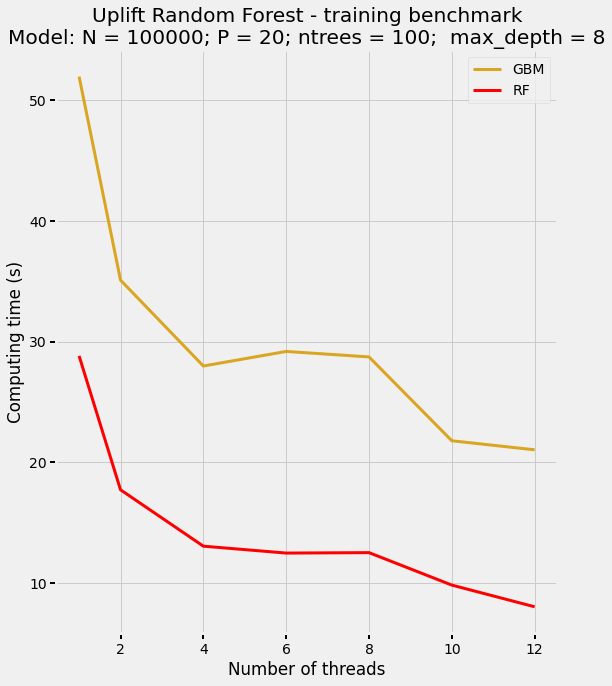

In [8]:
plot_result(gbm_time7, rf_time7)

In [9]:
N = 100000
P = 20
max_depth = 16
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [10]:
gbm_time8, rf_time8 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpvmf5g4mi
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpvmf5g4mi\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpvmf5g4mi\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,28 minutes
H2O_cluster_name:,H2O_from_python_valen_w90viu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 220.60036730766296s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 81.3784818649292s
H2O session _sid_899e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmptwtel023
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmptwtel023\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmptwtel023\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,34 minutes
H2O_cluster_name:,H2O_from_python_valen_eo2cfq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 227.439936876297s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 81.69795441627502s
H2O session _sid_a4c9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmppv19v4b_
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmppv19v4b_\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmppv19v4b_\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,39 minutes
H2O_cluster_name:,H2O_from_python_valen_5brl8m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 239.1426544189453s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.96803879737854s
H2O session _sid_a0a5 closed.
Uplift 229.06098620096842s
RF 82.34815835952759s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp9ofttmkf
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp9ofttmkf\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp9ofttmkf\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,45 minutes
H2O_cluster_name:,H2O_from_python_valen_maokpm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 225.03200912475586s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.68354487419128s
H2O session _sid_8a55 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpwurhvib1
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpwurhvib1\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpwurhvib1\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_valen_yubnny
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 217.8653655052185s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.13324785232544s
H2O session _sid_aa3e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpxxbn3ekl
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpxxbn3ekl\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpxxbn3ekl\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_valen_euiyps
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 223.68700885772705s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 81.32504653930664s
H2O session _sid_bf61 closed.
Uplift 222.19479449590048s
RF 83.04727975527446s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpj_hfcc29
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpj_hfcc29\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpj_hfcc29\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 2 minutes
H2O_cluster_name:,H2O_from_python_valen_dpv74x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 205.25504064559937s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.01184964179993s
H2O session _sid_be83 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpx3iucta_
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpx3iucta_\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpx3iucta_\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 7 minutes
H2O_cluster_name:,H2O_from_python_valen_alwwy1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 209.78446459770203s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.60201382637024s
H2O session _sid_a2fe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpak38buwu
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpak38buwu\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpak38buwu\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 12 minutes
H2O_cluster_name:,H2O_from_python_valen_rfd7k9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 202.73826622962952s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.07872462272644s
H2O session _sid_b260 closed.
Uplift 205.9259238243103s
RF 77.56419603029887s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpuyymuny6
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpuyymuny6\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpuyymuny6\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 17 minutes
H2O_cluster_name:,H2O_from_python_valen_fygtx4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 192.38394927978516s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 71.74554085731506s
H2O session _sid_9968 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmph_lhwe6q
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmph_lhwe6q\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmph_lhwe6q\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 22 minutes
H2O_cluster_name:,H2O_from_python_valen_hetkpf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 193.34148168563843s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.73878026008606s
H2O session _sid_a03a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpweb4x0f2
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpweb4x0f2\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpweb4x0f2\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 27 minutes
H2O_cluster_name:,H2O_from_python_valen_32n6wb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 189.1331467628479s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.25647592544556s
H2O session _sid_bf93 closed.
Uplift 191.61952590942383s
RF 73.24693234761556s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpqfqhepcg
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpqfqhepcg\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpqfqhepcg\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 31 minutes
H2O_cluster_name:,H2O_from_python_valen_of5onr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.4587800502777s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 71.46363711357117s
H2O session _sid_8c03 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpsug73o2n
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpsug73o2n\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpsug73o2n\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 36 minutes
H2O_cluster_name:,H2O_from_python_valen_lt7ryn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.08837151527405s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 71.76500058174133s
H2O session _sid_a8cd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpjwfkqai9
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpjwfkqai9\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpjwfkqai9\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 41 minutes
H2O_cluster_name:,H2O_from_python_valen_s6g2gb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 186.06095027923584s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 72.71250653266907s
H2O session _sid_b6e5 closed.
Uplift 183.86936728159586s
RF 71.9803814093272s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp_uatpp83
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp_uatpp83\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp_uatpp83\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 45 minutes
H2O_cluster_name:,H2O_from_python_valen_tfofzr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 213.0317895412445s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.27154541015625s
H2O session _sid_b166 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpzsblb2l6
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpzsblb2l6\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpzsblb2l6\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 51 minutes
H2O_cluster_name:,H2O_from_python_valen_kc4e9e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 208.22415447235107s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.1836245059967s
H2O session _sid_9be6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmppdwevctq
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmppdwevctq\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmppdwevctq\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 56 minutes
H2O_cluster_name:,H2O_from_python_valen_8plud2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 208.05126357078552s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.35105752944946s
H2O session _sid_b883 closed.
Uplift 209.7690691947937s
RF 93.26874248186748s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpzzet2med
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpzzet2med\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpzzet2med\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_valen_n3ino3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 286.5263602733612s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 148.50953817367554s
H2O session _sid_8fcc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp6rqsnclu
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp6rqsnclu\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp6rqsnclu\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_valen_j79mvt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 284.71637654304504s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.0013291835785s
H2O session _sid_b3ea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpmessehoz
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpmessehoz\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpmessehoz\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_valen_njq5qu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 281.45059156417847s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.04940724372864s
H2O session _sid_af61 closed.
Uplift 284.2311094601949s
RF 146.85342486699423s
12 - Uplift = 229.06098620096842, RF = 82.34815835952759
10 - Uplift = 222.19479449590048, RF = 83.04727975527446
8 - Uplift = 205.9259238243103, RF = 77.56419603029887
6 - Uplift = 191.61952590942383, RF = 73.24693234761556
4 - Uplift = 183.86936728159586, RF = 71.9803814093272
2 - Uplift = 209.7690691947937, RF = 93.26874248186748
1 - Uplift = 284.2311094601949, RF = 146.85342486699423


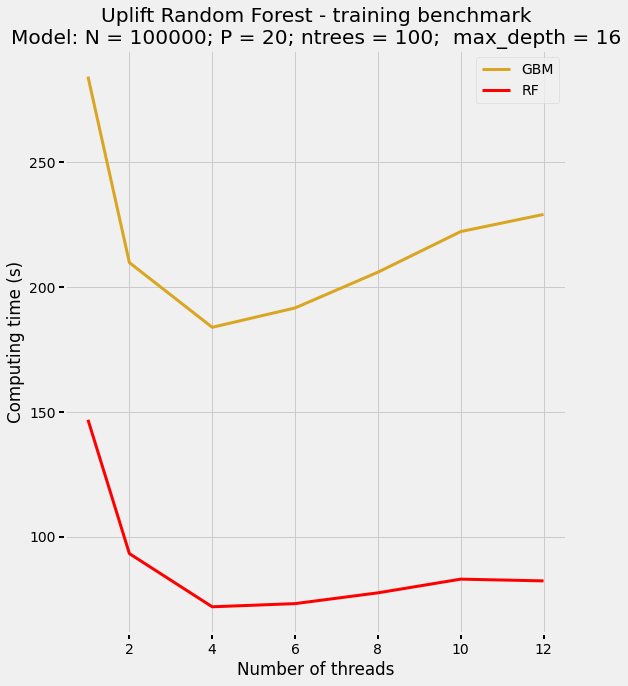

In [11]:
plot_result(gbm_time8, rf_time8)

### Bigger sample_size

In [12]:
N = 100000
P = 20
max_depth = 20
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [13]:
gbm_time9, rf_time9 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmphqbsa18a
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmphqbsa18a\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmphqbsa18a\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_valen_idwzvh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 421.6800904273987s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.73809933662415s
H2O session _sid_8581 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp1h2lqf9x
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp1h2lqf9x\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp1h2lqf9x\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_valen_4hq4dj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 461.83937764167786s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.41756939888s
H2O session _sid_ae67 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpc69m1iec
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpc69m1iec\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpc69m1iec\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_valen_dkdqb2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 440.6771664619446s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 101.34256601333618s
H2O session _sid_b04e closed.
Uplift 441.398878177007s
RF 99.49941158294678s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpzzdl8wiu
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpzzdl8wiu\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpzzdl8wiu\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_valen_oosf30
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 401.29496574401855s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.55064272880554s
H2O session _sid_bfd7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp7ud3_y85
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp7ud3_y85\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp7ud3_y85\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_valen_u3pq5l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 404.98810338974s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.74856352806091s
H2O session _sid_a5ec closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp392pfrix
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp392pfrix\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp392pfrix\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_valen_rm26ai
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 399.12896633148193s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.51093411445618s
H2O session _sid_84e0 closed.
Uplift 401.8040118217468s
RF 100.60338012377422s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmptsst6e0f
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmptsst6e0f\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmptsst6e0f\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_valen_yjlgop
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 373.2989056110382s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.25100469589233s
H2O session _sid_b875 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmplmflayie
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmplmflayie\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmplmflayie\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_valen_f3xiq8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 371.0489363670349s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.27047204971313s
H2O session _sid_9f33 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpphz3lfh8
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpphz3lfh8\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpphz3lfh8\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_valen_78qmgm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 376.9854118824005s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.26997256278992s
H2O session _sid_bfb8 closed.
Uplift 373.7777512868245s
RF 94.26381643613179s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpaxib2hg2
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpaxib2hg2\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpaxib2hg2\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server 

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_valen_y085tp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 349.8815896511078s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.3026351928711s
H2O session _sid_933e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpsk5m1xy0
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpsk5m1xy0\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpsk5m1xy0\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_valen_871egm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 348.4223823547363s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.12922978401184s
H2O session _sid_a9dd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpovyxu11p
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpovyxu11p\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpovyxu11p\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_valen_g7jc21
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 348.99470114707947s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 88.12345695495605s
H2O session _sid_868c closed.
Uplift 349.0995577176412s
RF 88.85177397727966s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpv6o6hmax
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpv6o6hmax\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpv6o6hmax\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_valen_hnyadk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 330.1408860683441s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.10352540016174s
H2O session _sid_9257 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpct2ly5wf
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpct2ly5wf\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpct2ly5wf\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_valen_50bp9v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 328.9842028617859s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.19074368476868s
H2O session _sid_92ae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpk299dvl6
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpk299dvl6\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpk299dvl6\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_valen_dsxk8p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 323.98342537879944s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 88.17626523971558s
H2O session _sid_aa2d closed.
Uplift 327.7028381029765s
RF 89.156844774882s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpjo_m8a52
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpjo_m8a52\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpjo_m8a52\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_valen_duqea5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 372.2918801307678s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 113.32069420814514s
H2O session _sid_9557 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp6ad1tkvq
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp6ad1tkvq\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp6ad1tkvq\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_valen_htaksf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 364.0155756473541s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 115.4038360118866s
H2O session _sid_9acc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp49z56j5c
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp49z56j5c\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp49z56j5c\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_valen_4h9gap
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 368.15116834640503s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 111.63319969177246s
H2O session _sid_b517 closed.
Uplift 368.15287470817566s
RF 113.45257663726807s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpz8eaywsf
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpz8eaywsf\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpz8eaywsf\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O ser

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_valen_lxinrw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 492.3530089855194s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 177.5460262298584s
H2O session _sid_882b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpkdkjhr61
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpkdkjhr61\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpkdkjhr61\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_valen_n4jn4l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 490.014200925827s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 168.62281107902527s
H2O session _sid_b076 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmplrsisev1
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmplrsisev1\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmplrsisev1\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_valen_koqofm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 457.99584317207336s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 168.1246109008789s
H2O session _sid_aff5 closed.
Uplift 480.12101769447327s
RF 171.43114940325418s
12 - Uplift = 441.398878177007, RF = 99.49941158294678
10 - Uplift = 401.8040118217468, RF = 100.60338012377422
8 - Uplift = 373.7777512868245, RF = 94.26381643613179
6 - Uplift = 349.0995577176412, RF = 88.85177397727966
4 - Uplift = 327.7028381029765, RF = 89.156844774882
2 - Uplift = 368.15287470817566, RF = 113.45257663726807
1 - Uplift = 480.12101769447327, RF = 171.43114940325418


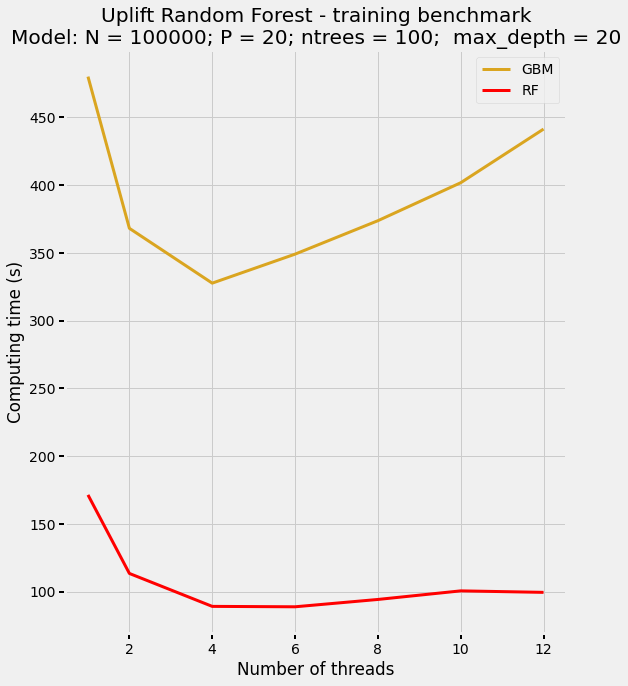

In [14]:
plot_result(gbm_time9, rf_time9)

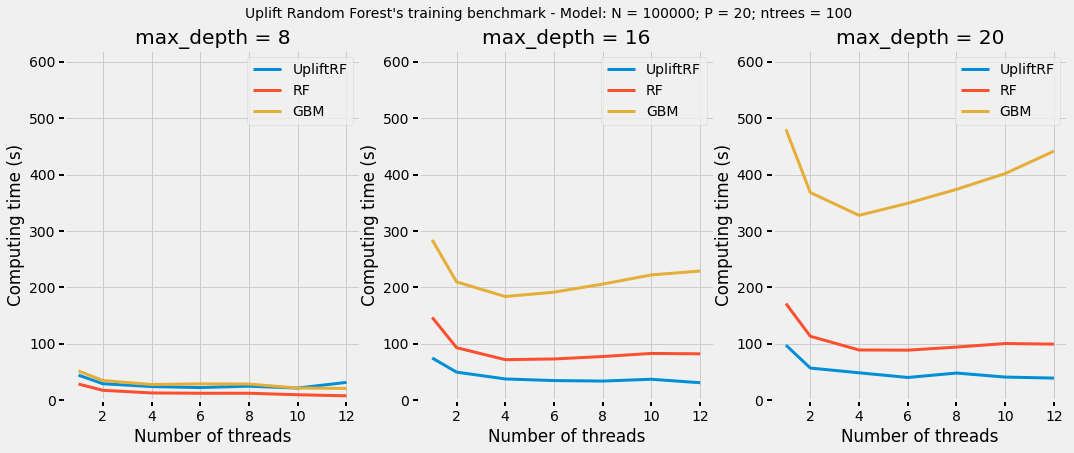

In [15]:
uplift_time7 = {12: 31.71, 10: 21.73, 8: 25.00, 6: 22.56, 4: 24.35, 2: 29.36, 1: 44.59}
uplift_time8 = {12: 31.12, 10: 37.28, 8: 34.11, 6: 34.95, 4: 37.82, 2: 49.90, 1: 74.91}
uplift_time9 = {12: 39.35, 10: 41.15, 8: 48.28, 6: 40.45, 4: 48.73, 2: 57.15, 1: 97.80}
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_gbm = [gbm_time7, gbm_time8, gbm_time9]
all_predict_rf = [rf_time7, rf_time8, rf_time9]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 620)
    plt.legend() 
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [16]:
print(all_predict_uplift)

[{12: 31.71, 10: 21.73, 8: 25.0, 6: 22.56, 4: 24.35, 2: 29.36, 1: 44.59}, {12: 31.12, 10: 37.28, 8: 34.11, 6: 34.95, 4: 37.82, 2: 49.9, 1: 74.91}, {12: 39.35, 10: 41.15, 8: 48.28, 6: 40.45, 4: 48.73, 2: 57.15, 1: 97.8}]


In [17]:
print(all_predict_gbm)

[{12: 21.035215457280476, 10: 21.784722805023193, 8: 28.734578529993694, 6: 29.18897493680318, 4: 27.981499751408894, 2: 35.100552002588906, 1: 51.96958017349243}, {12: 229.06098620096842, 10: 222.19479449590048, 8: 205.9259238243103, 6: 191.61952590942383, 4: 183.86936728159586, 2: 209.7690691947937, 1: 284.2311094601949}, {12: 441.398878177007, 10: 401.8040118217468, 8: 373.7777512868245, 6: 349.0995577176412, 4: 327.7028381029765, 2: 368.15287470817566, 1: 480.12101769447327}]


In [18]:
print(all_predict_rf)

[{12: 8.023581902186075, 10: 9.822240908940634, 8: 12.512465238571167, 6: 12.476433674494425, 4: 13.048354148864746, 2: 17.721863508224487, 1: 28.81749685605367}, {12: 82.34815835952759, 10: 83.04727975527446, 8: 77.56419603029887, 6: 73.24693234761556, 4: 71.9803814093272, 2: 93.26874248186748, 1: 146.85342486699423}, {12: 99.49941158294678, 10: 100.60338012377422, 8: 94.26381643613179, 6: 88.85177397727966, 4: 89.156844774882, 2: 113.45257663726807, 1: 171.43114940325418}]


In [5]:
nbinss = []

In [6]:
N = 100000
P = 20
max_depth = 16
nbins=20
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [7]:
gbm_time0, rf_time0 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpnyhvggj4
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpnyhvggj4\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpnyhvggj4\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
versionFromGradle='3.33.1',projectVersion='3.33.1.99999',branch='master',lastCommitHash='9cf06c72d5920cc46707735783b82da738ba3e20',gitDescribe='jenkins-master-5507',compiledOn='2021-07-18 14:13:16',compiledBy='valen'


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 minutes
H2O_cluster_name:,H2O_from_python_valen_o93npu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 60.297951221466064s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.17099928855896s
H2O session _sid_9058 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmphc2vgia1
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmphc2vgia1\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmphc2vgia1\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 minutes
H2O_cluster_name:,H2O_from_python_valen_b6610k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.77122640609741s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.289286375045776s
H2O session _sid_83b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp4oitz_vf
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp4oitz_vf\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp4oitz_vf\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 minutes
H2O_cluster_name:,H2O_from_python_valen_ogo7ts
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 58.47868275642395s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.0197651386261s
H2O session _sid_804a closed.
Uplift 58.849286794662476s
RF 32.826683600743614s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmprm79v628
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmprm79v628\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmprm79v628\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 minutes
H2O_cluster_name:,H2O_from_python_valen_kkp6ao
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 64.39882016181946s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.714958906173706s
H2O session _sid_b90e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpwy1_az40
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpwy1_az40\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpwy1_az40\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 minutes
H2O_cluster_name:,H2O_from_python_valen_50wflo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 59.04236912727356s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.543718099594116s
H2O session _sid_b57a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpzhuwijwl
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpzhuwijwl\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpzhuwijwl\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 minutes
H2O_cluster_name:,H2O_from_python_valen_phbyhz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 66.3249831199646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 37.26188516616821s
H2O session _sid_8889 closed.
Uplift 63.2553908030192s
RF 35.50685405731201s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpsxlsvm7u
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpsxlsvm7u\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpsxlsvm7u\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 minutes
H2O_cluster_name:,H2O_from_python_valen_w2oigt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 84.71266865730286s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 45.848615646362305s
H2O session _sid_bef8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp21oupy6m
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp21oupy6m\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp21oupy6m\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 minutes
H2O_cluster_name:,H2O_from_python_valen_if0szi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 76.73163390159607s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 38.67712068557739s
H2O session _sid_a4f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpn0_u_0i0
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpn0_u_0i0\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpn0_u_0i0\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 minutes
H2O_cluster_name:,H2O_from_python_valen_mrlx1a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.00696063041687s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 38.07531380653381s
H2O session _sid_b195 closed.
Uplift 76.4837543964386s
RF 40.8670167128245s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpnfk6eimx
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpnfk6eimx\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpnfk6eimx\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 minutes
H2O_cluster_name:,H2O_from_python_valen_4gqdi4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 63.00608277320862s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 38.837307929992676s
H2O session _sid_b4c6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp52yhic7h
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp52yhic7h\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp52yhic7h\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,25 minutes
H2O_cluster_name:,H2O_from_python_valen_clqa7q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.063116788864136s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.336445331573486s
H2O session _sid_9b59 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpgckhbvxc
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpgckhbvxc\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpgckhbvxc\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,27 minutes
H2O_cluster_name:,H2O_from_python_valen_ntcggb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 56.3431351184845s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.12316846847534s
H2O session _sid_955a closed.
Uplift 58.80411156018575s
RF 35.43230724334717s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpnhygvj05
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpnhygvj05\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpnhygvj05\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,29 minutes
H2O_cluster_name:,H2O_from_python_valen_80h5z7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 58.59208273887634s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 38.535123348236084s
H2O session _sid_8a43 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpuqglmu0c
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpuqglmu0c\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpuqglmu0c\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,31 minutes
H2O_cluster_name:,H2O_from_python_valen_23e3z5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.48102951049805s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.659111976623535s
H2O session _sid_846f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp8xnglcg1
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp8xnglcg1\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp8xnglcg1\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,33 minutes
H2O_cluster_name:,H2O_from_python_valen_jba4xf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 58.18249726295471s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.668193340301514s
H2O session _sid_9f40 closed.
Uplift 58.08520317077637s
RF 37.287476221720375s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpv09znwqc
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpv09znwqc\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpv09znwqc\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,35 minutes
H2O_cluster_name:,H2O_from_python_valen_52x7mz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.08347725868225s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.68849730491638s
H2O session _sid_a0a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpaw1g7xuh
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpaw1g7xuh\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpaw1g7xuh\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,37 minutes
H2O_cluster_name:,H2O_from_python_valen_lzok63
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.10668420791626s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.75275945663452s
H2O session _sid_bf3f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpxeiis6sb
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpxeiis6sb\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpxeiis6sb\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,40 minutes
H2O_cluster_name:,H2O_from_python_valen_6jioyx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.98393845558167s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.6629376411438s
H2O session _sid_b3ee closed.
Uplift 72.72469997406006s
RF 50.36806480089823s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpptntb284
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpptntb284\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpptntb284\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,42 minutes
H2O_cluster_name:,H2O_from_python_valen_gij42z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.1297390460968s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.7356128692627s
H2O session _sid_b472 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmptch7wqhz
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmptch7wqhz\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmptch7wqhz\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,46 minutes
H2O_cluster_name:,H2O_from_python_valen_ryw2qa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.45386576652527s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.04427313804626s
H2O session _sid_9c8a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpdktedndx
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpdktedndx\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpdktedndx\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,49 minutes
H2O_cluster_name:,H2O_from_python_valen_3tvihy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.9049961566925s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.20015215873718s
H2O session _sid_9641 closed.
Uplift 106.16286698977153s
RF 81.99334605534871s
12 - Uplift = 58.849286794662476, RF = 32.826683600743614
10 - Uplift = 63.2553908030192, RF = 35.50685405731201
8 - Uplift = 76.4837543964386, RF = 40.8670167128245
6 - Uplift = 58.80411156018575, RF = 35.43230724334717
4 - Uplift = 58.08520317077637, RF = 37.287476221720375
2 - Uplift = 72.72469997406006, RF = 50.36806480089823
1 - Uplift = 106.16286698977153, RF = 81.99334605534871


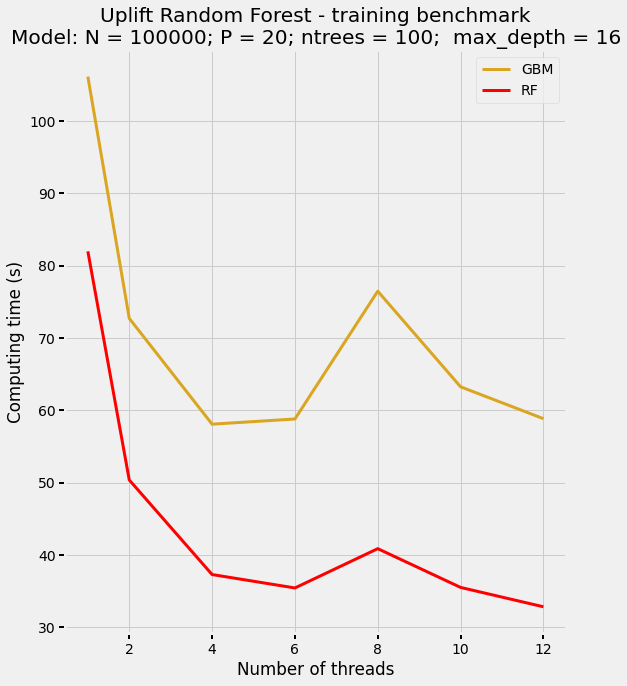

In [8]:
plot_result(gbm_time0, rf_time0)

In [9]:
N = 100000
P = 20
max_depth = 16
nbins=400
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [10]:
gbm_time1, rf_time1 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpppg1tyw7
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpppg1tyw7\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpppg1tyw7\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,H2O_from_python_valen_3saqo6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 133.82062673568726s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.25698447227478s
H2O session _sid_8ab3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpysopu3hk
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpysopu3hk\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpysopu3hk\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_valen_94au0q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 137.52216291427612s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.07655715942383s
H2O session _sid_a62b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpe9aldzhy
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpe9aldzhy\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpe9aldzhy\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour
H2O_cluster_name:,H2O_from_python_valen_sl6hj0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 151.6467649936676s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.33864426612854s
H2O session _sid_812d closed.
Uplift 140.99651821454367s
RF 62.89072863260905s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmplv31f9fu
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmplv31f9fu\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmplv31f9fu\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 4 minutes
H2O_cluster_name:,H2O_from_python_valen_4j0b69
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 127.33710646629333s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.12872624397278s
H2O session _sid_984f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmptv7j7bjo
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmptv7j7bjo\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmptv7j7bjo\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 8 minutes
H2O_cluster_name:,H2O_from_python_valen_cf83em
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 124.97952008247375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.68041777610779s
H2O session _sid_acf3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpxp2wr1kv
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpxp2wr1kv\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpxp2wr1kv\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 11 minutes
H2O_cluster_name:,H2O_from_python_valen_f90m64
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 125.2830822467804s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.712754249572754s
H2O session _sid_a499 closed.
Uplift 125.86656959851582s
RF 58.17396608988444s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp2guyzj2_
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp2guyzj2_\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp2guyzj2_\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 15 minutes
H2O_cluster_name:,H2O_from_python_valen_evrg8f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.40807938575745s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.92628240585327s
H2O session _sid_9a5d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp9iurkcx0
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp9iurkcx0\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp9iurkcx0\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 18 minutes
H2O_cluster_name:,H2O_from_python_valen_q0dlhe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.08270502090454s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.69406747817993s
H2O session _sid_b6d4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpcvaxf7fz
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpcvaxf7fz\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpcvaxf7fz\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 21 minutes
H2O_cluster_name:,H2O_from_python_valen_g3qii4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.07643556594849s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.451661586761475s
H2O session _sid_a263 closed.
Uplift 119.18907332420349s
RF 55.69067049026489s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpffm34wsc
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpffm34wsc\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpffm34wsc\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serv

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 24 minutes
H2O_cluster_name:,H2O_from_python_valen_ci90el
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 118.63948225975037s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.33051109313965s
H2O session _sid_ba03 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpcsnk8v6i
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpcsnk8v6i\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpcsnk8v6i\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 28 minutes
H2O_cluster_name:,H2O_from_python_valen_u0lxt4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 117.3244776725769s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.76369285583496s
H2O session _sid_9f90 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp4vfxmg_a
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp4vfxmg_a\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp4vfxmg_a\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 31 minutes
H2O_cluster_name:,H2O_from_python_valen_omp2l4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 117.45441961288452s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.480329275131226s
H2O session _sid_b2e7 closed.
Uplift 117.8061265150706s
RF 53.858177741368614s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpmyuzthq2
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpmyuzthq2\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpmyuzthq2\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serv

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 34 minutes
H2O_cluster_name:,H2O_from_python_valen_dsn53w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.95560622215271s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.43816089630127s
H2O session _sid_890e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpwoxxtmk9
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpwoxxtmk9\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpwoxxtmk9\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 37 minutes
H2O_cluster_name:,H2O_from_python_valen_qsdceb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.34757208824158s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.6386878490448s
H2O session _sid_a3fd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpfkem6tdr
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpfkem6tdr\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpfkem6tdr\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 41 minutes
H2O_cluster_name:,H2O_from_python_valen_vgq3k4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.33145952224731s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.70113277435303s
H2O session _sid_8bc3 closed.
Uplift 112.21154594421387s
RF 56.25932717323303s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp3hplb4ax
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp3hplb4ax\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp3hplb4ax\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 44 minutes
H2O_cluster_name:,H2O_from_python_valen_hgcpil
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.0699372291565s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.1299979686737s
H2O session _sid_a5b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpxqiso39_
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpxqiso39_\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpxqiso39_\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 48 minutes
H2O_cluster_name:,H2O_from_python_valen_e7siij
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.07198214530945s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 71.98479652404785s
H2O session _sid_ab45 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpjqxeut72
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpjqxeut72\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpjqxeut72\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 52 minutes
H2O_cluster_name:,H2O_from_python_valen_f7gjbc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 133.96297526359558s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 72.19018936157227s
H2O session _sid_83dc closed.
Uplift 134.03496487935385s
RF 72.43499461809795s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp3si21j1q
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp3si21j1q\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp3si21j1q\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 55 minutes
H2O_cluster_name:,H2O_from_python_valen_h30x34
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 189.36770915985107s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 116.89660024642944s
H2O session _sid_8f73 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmphijpqpdb
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmphijpqpdb\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmphijpqpdb\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 1 minute
H2O_cluster_name:,H2O_from_python_valen_84d1n2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 190.53385400772095s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 114.41060161590576s
H2O session _sid_b938 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpao0p77f7
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpao0p77f7\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpao0p77f7\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_valen_d8999k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 185.4349992275238s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 114.21793389320374s
H2O session _sid_ba1d closed.
Uplift 188.44552079836527s
RF 115.17504525184631s
12 - Uplift = 140.99651821454367, RF = 62.89072863260905
10 - Uplift = 125.86656959851582, RF = 58.17396608988444
8 - Uplift = 119.18907332420349, RF = 55.69067049026489
6 - Uplift = 117.8061265150706, RF = 53.858177741368614
4 - Uplift = 112.21154594421387, RF = 56.25932717323303
2 - Uplift = 134.03496487935385, RF = 72.43499461809795
1 - Uplift = 188.44552079836527, RF = 115.17504525184631


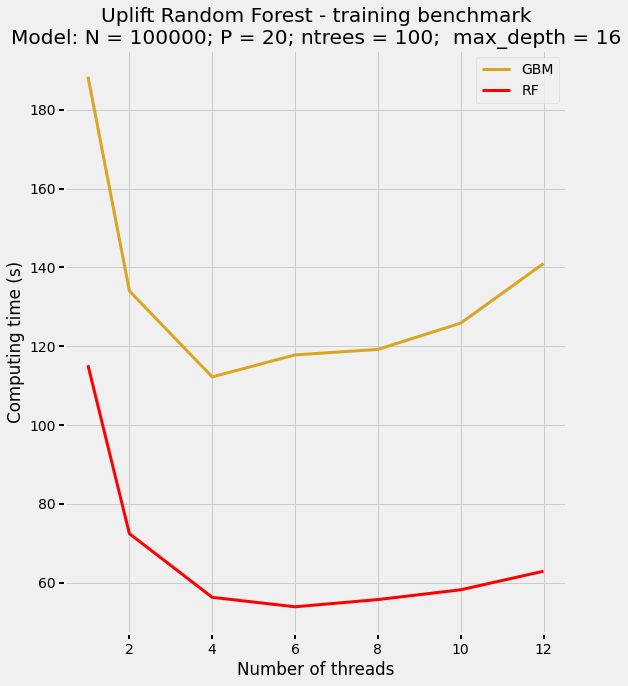

In [11]:
plot_result(gbm_time1, rf_time1)

In [12]:
N = 100000
P = 20
max_depth = 16
nbins_top_level=2500
nbins=2000
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [13]:
gbm_time2, rf_time2 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp8qw1_3_h
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp8qw1_3_h\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp8qw1_3_h\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_valen_3an8r0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 499.8831100463867s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 159.3918752670288s
H2O session _sid_9469 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpoi17g8tq
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpoi17g8tq\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpoi17g8tq\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_valen_e8wlr8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 504.59563636779785s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 160.41618752479553s
H2O session _sid_b7e3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpes7td4gc
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpes7td4gc\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpes7td4gc\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_valen_6o3a2d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 499.8611788749695s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 160.7052435874939s
H2O session _sid_8136 closed.
Uplift 501.44664176305133s
RF 160.17110212643942s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpcj1ba43l
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpcj1ba43l\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpcj1ba43l\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_valen_0e8gjb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 464.20031213760376s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 151.55865597724915s
H2O session _sid_98cb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp51mmnn68
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp51mmnn68\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp51mmnn68\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_valen_54ijwa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 471.97161889076233s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 152.4480013847351s
H2O session _sid_aff0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpe2_b911d
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpe2_b911d\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpe2_b911d\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_valen_plmjeu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 468.9880921840668s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 151.02838683128357s
H2O session _sid_ac72 closed.
Uplift 468.3866744041443s
RF 151.6783480644226s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpmekmn6mj
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpmekmn6mj\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpmekmn6mj\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_valen_wfc106
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 437.5994646549225s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.38074922561646s
H2O session _sid_98ba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpj38_xcb7
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpj38_xcb7\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpj38_xcb7\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_valen_745yz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 436.42403411865234s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 141.5907483100891s
H2O session _sid_aa49 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpz95r99rt
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpz95r99rt\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpz95r99rt\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_valen_j1c1zv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 435.63132309913635s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 141.28022527694702s
H2O session _sid_b2d7 closed.
Uplift 436.55160729090375s
RF 142.08390760421753s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmppf52nxit
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmppf52nxit\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmppf52nxit\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O ser

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_valen_39ecym
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 407.21379566192627s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 130.36562061309814s
H2O session _sid_bec2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpf6hcb5ub
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpf6hcb5ub\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpf6hcb5ub\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_valen_da1vx7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 419.5629653930664s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 132.32087469100952s
H2O session _sid_ba4f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpaavbgfxu
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpaavbgfxu\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpaavbgfxu\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_valen_h2e4l2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 408.23583936691284s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 130.4188039302826s
H2O session _sid_9bd1 closed.
Uplift 411.6708668073018s
RF 131.03509974479675s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmplsjrzu1w
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmplsjrzu1w\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmplsjrzu1w\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_valen_9os96c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 397.5963177680969s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 133.7561423778534s
H2O session _sid_aa93 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp9l2ahbqu
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp9l2ahbqu\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp9l2ahbqu\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_valen_kc36ol
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 391.89854407310486s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 128.4967062473297s
H2O session _sid_9fee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpegrgbcrd
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpegrgbcrd\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpegrgbcrd\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_valen_2b1ghw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 395.73620867729187s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 130.95358967781067s
H2O session _sid_bc90 closed.
Uplift 395.07702350616455s
RF 131.06881276766458s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpsa45cecw
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpsa45cecw\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpsa45cecw\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O ser

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_valen_tndt3m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 443.2158706188202s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 162.57856059074402s
H2O session _sid_aa9d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpk735_v4x
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpk735_v4x\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpk735_v4x\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_valen_dqz3w2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 443.6997730731964s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 167.50220894813538s
H2O session _sid_ba88 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpxhyfxwdb
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpxhyfxwdb\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpxhyfxwdb\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_valen_2fq0zi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 432.7773790359497s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 158.68841576576233s
H2O session _sid_af6f closed.
Uplift 439.89767424265546s
RF 162.9230617682139s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp4hvt32b7
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp4hvt32b7\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp4hvt32b7\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_valen_ttqmrm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 571.7764132022858s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 250.5419454574585s
H2O session _sid_8b51 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmpqbw_lilc
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmpqbw_lilc\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmpqbw_lilc\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_valen_ccfitd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 573.9637339115143s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 250.66037511825562s
H2O session _sid_ac0e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\valen\h2o-3\build\h2o.jar
  Ice root: C:\Users\valen\AppData\Local\Temp\tmp40ychv3w
  JVM stdout: C:\Users\valen\AppData\Local\Temp\tmp40ychv3w\h2o_valen_started_from_python.out
  JVM stderr: C:\Users\valen\AppData\Local\Temp\tmp40ychv3w\h2o_valen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_valen_sz4esp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.058 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Uplift Time: 554.3130693435669s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 241.07868075370789s
H2O session _sid_9122 closed.
Uplift 566.684405485789s
RF 247.42700044314066s
12 - Uplift = 501.44664176305133, RF = 160.17110212643942
10 - Uplift = 468.3866744041443, RF = 151.6783480644226
8 - Uplift = 436.55160729090375, RF = 142.08390760421753
6 - Uplift = 411.6708668073018, RF = 131.03509974479675
4 - Uplift = 395.07702350616455, RF = 131.06881276766458
2 - Uplift = 439.89767424265546, RF = 162.9230617682139
1 - Uplift = 566.684405485789, RF = 247.42700044314066


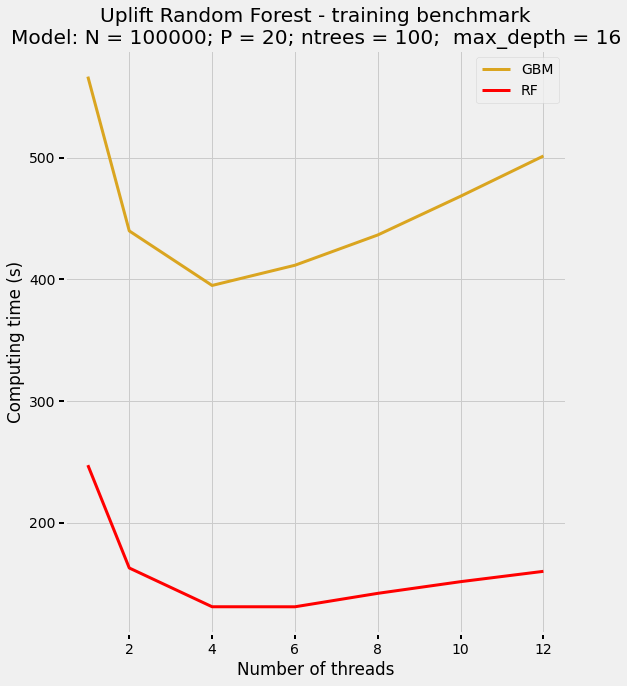

In [14]:
plot_result(gbm_time2, rf_time2)

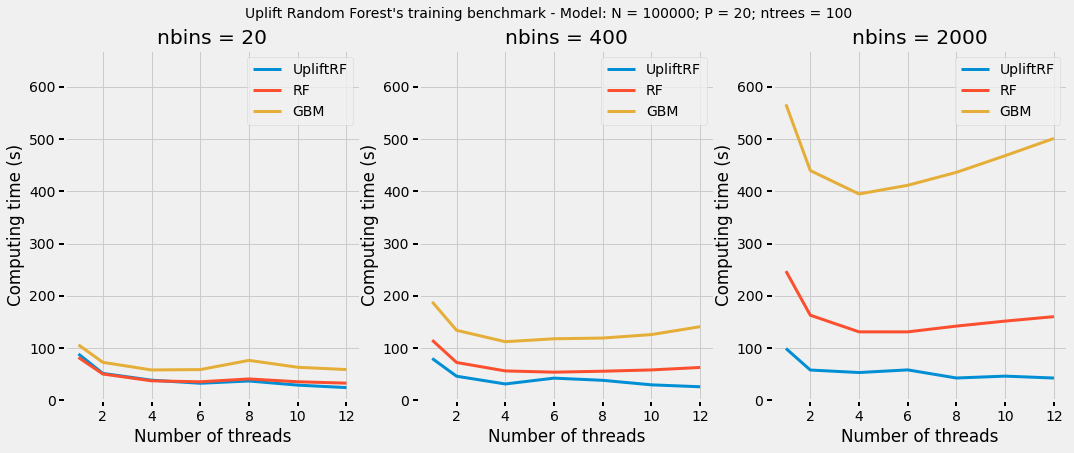

In [19]:
uplift_time0 = {12: 24.35, 10: 29.06, 8: 36.97, 6: 32.61, 4: 38.51, 2: 51.48, 1: 88.75}
uplift_time1 = {12: 25.90, 10: 29.60, 8: 38.25, 6: 42.44, 4: 31.27, 2: 46.10, 1: 80.07}
uplift_time2 = {12: 42.63, 10: 46.28, 8: 42.68, 6: 58.23, 4: 53.17, 2: 57.97, 1: 99.22}
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_gbm = [gbm_time0, gbm_time1, gbm_time2]
all_predict_rf = [rf_time0, rf_time1, rf_time2]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)  
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 670)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [16]:
print(all_predict_uplift)

[{12: 24.35, 10: 29.06, 8: 36.97, 6: 32.61, 4: 38.51, 2: 51.48, 1: 88.75}, {12: 25.9, 10: 29.6, 8: 38.25, 6: 42.44, 4: 31.27, 2: 46.1, 1: 80.07}, {12: 42.63, 10: 46.28, 8: 42.68, 6: 58.23, 4: 53.17, 2: 57.97, 1: 99.22}]


In [17]:
print(all_predict_gbm)

[{12: 58.849286794662476, 10: 63.2553908030192, 8: 76.4837543964386, 6: 58.80411156018575, 4: 58.08520317077637, 2: 72.72469997406006, 1: 106.16286698977153}, {12: 140.99651821454367, 10: 125.86656959851582, 8: 119.18907332420349, 6: 117.8061265150706, 4: 112.21154594421387, 2: 134.03496487935385, 1: 188.44552079836527}, {12: 501.44664176305133, 10: 468.3866744041443, 8: 436.55160729090375, 6: 411.6708668073018, 4: 395.07702350616455, 2: 439.89767424265546, 1: 566.684405485789}]


In [18]:
print(all_predict_rf)

[{12: 32.826683600743614, 10: 35.50685405731201, 8: 40.8670167128245, 6: 35.43230724334717, 4: 37.287476221720375, 2: 50.36806480089823, 1: 81.99334605534871}, {12: 62.89072863260905, 10: 58.17396608988444, 8: 55.69067049026489, 6: 53.858177741368614, 4: 56.25932717323303, 2: 72.43499461809795, 1: 115.17504525184631}, {12: 160.17110212643942, 10: 151.6783480644226, 8: 142.08390760421753, 6: 131.03509974479675, 4: 131.06881276766458, 2: 162.9230617682139, 1: 247.42700044314066}]


## Evaluation Stage

In [ ]:
def run_predict(EIF_model, IF_model, hf_test):
    start = time.time()
    EIF_model.predict(hf_test)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_model.predict(hf_test)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")    
    return eif_time, if_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        h2o.init(nthreads=nthreads)     
        hf_train = h2o.H2OFrame(train_data)    
        hf_test = h2o.H2OFrame(test_data)
        EIF_model = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                             ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = P - 1)
        EIF_model.train(training_frame = hf_train)
        IF_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth+1)
        IF_model.train(training_frame = hf_train)
        for i in range(attempt_per_thread):
            eif_time, if_time = run_predict(EIF_model, IF_model, hf_test)
            times_eif.append(eif_time)
            times_if.append(if_time)
        h2o.cluster().shutdown()
        print(f"EIF {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")
        
        
    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])

    return eif_means, if_means 

def plot_predict(EIF_means, IF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in EIF_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in IF_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
    # plt.grid("off")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Extended Isolation Forest - evaluation benchmark\nModel: N = {N_train}; P = {P}; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}\nEvaluation Frame: N = {N}; P = {P}")
    plt.savefig(f"h2o-eval-perf_{sample_size}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [ ]:
# Evaluation stage parameters

N = 500
P = 2
N_train = 500
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time18, if_time18 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time18, if_time18)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 30
N_train = 500_000
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time10, if_time10 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time10, if_time10)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 5_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time11, if_time11 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time11, if_time11)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 20_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time12, if_time12 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time12, if_time12)

### Real Credit Card Fraud Detection Data

In [ ]:
sample_sizes = []

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = 256
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time14, if_time14 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time14, if_time14)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.01)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time15, if_time15 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time15, if_time15)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.05)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time16, if_time16 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time16, if_time16)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.10)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time17, if_time17 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time17, if_time17)

In [ ]:
all_predict_eif = [eif_time14, eif_time15, eif_time16]
all_predict_if = [if_time14, if_time15, if_time16]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Extended Isolation Forest's scoring benchmark - Frame to score: N = {N}; P = {P}. Model: N = {N_train}; P = {P}; ntrees = {ntrees}.", fontsize=14)

for eif_time, if_time, i in zip(all_predict_eif, all_predict_if, range(1, len(sample_sizes) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"EIF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in if_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"IF", linewidth=3)    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 40)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"sample_size = {sample_sizes[i - 1]}; max_depth = {math.ceil(math.log(sample_sizes[i - 1], 2))}")

plt.savefig(f"h2o-score-perf_credit{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()